# RNN Implementation and Experiments

This notebook demonstrates the RNN implementation and experiments. We'll work with the NusaX-Sentiment dataset to perform text classification.

In [44]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense, Bidirectional
from sklearn.metrics import f1_score, classification_report

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from src.models.src.models.base_model.utils.nusax_loader import NusaXLoader
from src.models.src.models.rnn.experiment import RNNExperiments
from src.models.src.models.rnn.rnn_model import RNNModel
from src.models.src.models.rnn.rnn_layer import RNNLayer
from src.models.src.models.base_model.layers.embedding_layer import EmbeddingLayer
from src.models.src.models.base_model.layers.dense_layer import DenseLayer
from src.models.src.models.base_model.layers.dropout_layer import DropoutLayer
from src.models.src.models.base_model.layers.activation_layer import Softmax
from src.models.src.models.base_model.utils.evaluation import compare_keras_vs_scratch
from src.models.src.models.base_model.utils.visualization import plot_training_history

In [46]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Num GPUs Available: {len(gpus)}")
        print(f"Num Logical GPUs: {len(logical_gpus)}")
    except RuntimeError as e:
        print(e)


Num GPUs Available: 1
Num Logical GPUs: 1


## 1. Load Data

In [47]:
# Init data loader
data_loader = NusaXLoader(batch_size=32, add=True)
# Ini add buat ngubah pathnya nambah "../" tapi harusnya gaperlu soalnya di file siblingnsnya juga gapake ini, api entah kenapa gabisa jalan kalo gadipasang

# Train
train_dataset = data_loader.get_dataset('train')
for tokens, labels in train_dataset.take(1):
    sample_tokens = tokens.numpy()
    sample_labels = labels.numpy()
    break

# Get vocabulary
vocab = data_loader.get_vocabulary()
print(f"Vocabulary size: {len(vocab)}")
print(f"First 20 words in vocabulary: {vocab[:20]}")

# Output Example
print("\nSample texts:")
for i in range(3):
    # Convert token IDs back to words
    words = [vocab[idx] if idx < len(vocab) else "[UNK]" for idx in sample_tokens[i] if idx > 0]
    text = " ".join(words)
    print(f"Text {i+1}: {text}")
    print(f"Label: {sample_labels[i]}\n")

Vocabulary size: 2836
First 20 words in vocabulary: ['', '[UNK]', np.str_('yang'), np.str_('di'), np.str_('dan'), np.str_('tidak'), np.str_('saya'), np.str_('dengan'), np.str_('enak'), np.str_('ini'), np.str_('makan'), np.str_('untuk'), np.str_('ke'), np.str_('tempat'), np.str_('makanan'), np.str_('juga'), np.str_('sangat'), np.str_('ada'), np.str_('banyak'), np.str_('karena')]

Sample texts:
Text 1: nikmati cicilan 0 hingga 12 bulan untuk pemesanan tiket pesawat air asia dengan kartu kredit bni
Label: 1

Text 2: kuekue yang disajikan bikin saya bernostalgia semuanya tipikal kue zaman dulu baik dari penampilan maupun rasa kuenya enak dan harganya juga murah
Label: 2

Text 3: ibu pernah bekerja di grab indonesia
Label: 1



## 2. Hyperparameter Experiments with RNN

In [48]:
experiments = RNNExperiments(data_loader=data_loader, batch_size=32, epochs=10, embedding_dim=100)

Vocabulary size: 2836
Number of classes: 3
Maximum sequence length: 100
Batch size: 32
Epochs: 10
Embedding dimension: 100


### 2.1 Experiment: Number of RNN Layers


=== Training model with 1 RNN Layer ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.3594 - loss: 1.1035 - val_accuracy: 0.3800 - val_loss: 1.0844
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4664 - loss: 1.0262 - val_accuracy: 0.3400 - val_loss: 1.1289
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7148 - loss: 0.8124 - val_accuracy: 0.3600 - val_loss: 1.1910
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8392 - loss: 0.6076 - val_accuracy: 0.4000 - val_loss: 1.2327
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8294 - loss: 0.5371 - val_accuracy: 0.3300 - val_loss: 1.4155
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7599 - loss: 0.5981 - val_accuracy: 0.3900 - val_loss: 1.5531
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7402 - loss: 0.6505 - val_accuracy: 0.3300 - val_loss: 1.5453
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2740 - loss: 1.7479 - val_accuracy: 0.2400 - val_loss: 1

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_22 (SimpleRNN)       │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883,067 (3.37 MB)

 Trainable params: 294,355 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 588,712 (2.25 MB)


=== Training model with 2 RNN Layers ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.3448 - loss: 1.1614 - val_accuracy: 0.3800 - val_loss: 1.0803
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3583 - loss: 1.1470 - val_accuracy: 0.3400 - val_loss: 1.1047
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4570 - loss: 1.0606 - val_accuracy: 0.4400 - val_loss: 1.1479
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5401 - loss: 0.9901 - val_accuracy: 0.4000 - val_loss: 1.2220
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3473 - loss: 1.1608 - val_accuracy: 0.3200 - val_loss: 1.3117
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3031 - loss: 1.3543 - val_accuracy: 0.3200 - val_loss: 1.1894
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3123 - loss: 1.2438 - val_accuracy: 0.3900 - val_loss: 1.1428
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4227 - loss: 1.0608 - val_accuracy: 0.3900 - val_loss: 1

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_23 (SimpleRNN)       │ (None, 100, 64)        │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_24 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 907,835 (3.46 MB)

 Trainable params: 302,611 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 605,224 (2.31 MB)


=== Training model with 3 RNN Layers ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 261ms/step - accuracy: 0.3482 - loss: 1.3259 - val_accuracy: 0.3800 - val_loss: 1.1436
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3085 - loss: 1.2896 - val_accuracy: 0.3800 - val_loss: 1.0824
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3425 - loss: 1.1848 - val_accuracy: 0.3800 - val_loss: 1.0857
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3525 - loss: 1.1909 - val_accuracy: 0.3800 - val_loss: 1.0925
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.3683 - loss: 1.2079 - val_accuracy: 0.3800 - val_loss: 1.1262
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3655 - loss: 1.1498 - val_accuracy: 0.3800 - val_loss: 1.0837
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3888 - loss: 1.1262 - val_accuracy: 0.3800 - val_loss: 1.1009
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4102 - loss: 1.1889 - val_accuracy: 0.3500 - val_loss: 

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_25 (SimpleRNN)       │ (None, 100, 64)        │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_26 (SimpleRNN)       │ (None, 100, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_27 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 932,603 (3.56 MB)

 Trainable params: 310,867 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 621,736 (2.37 MB)

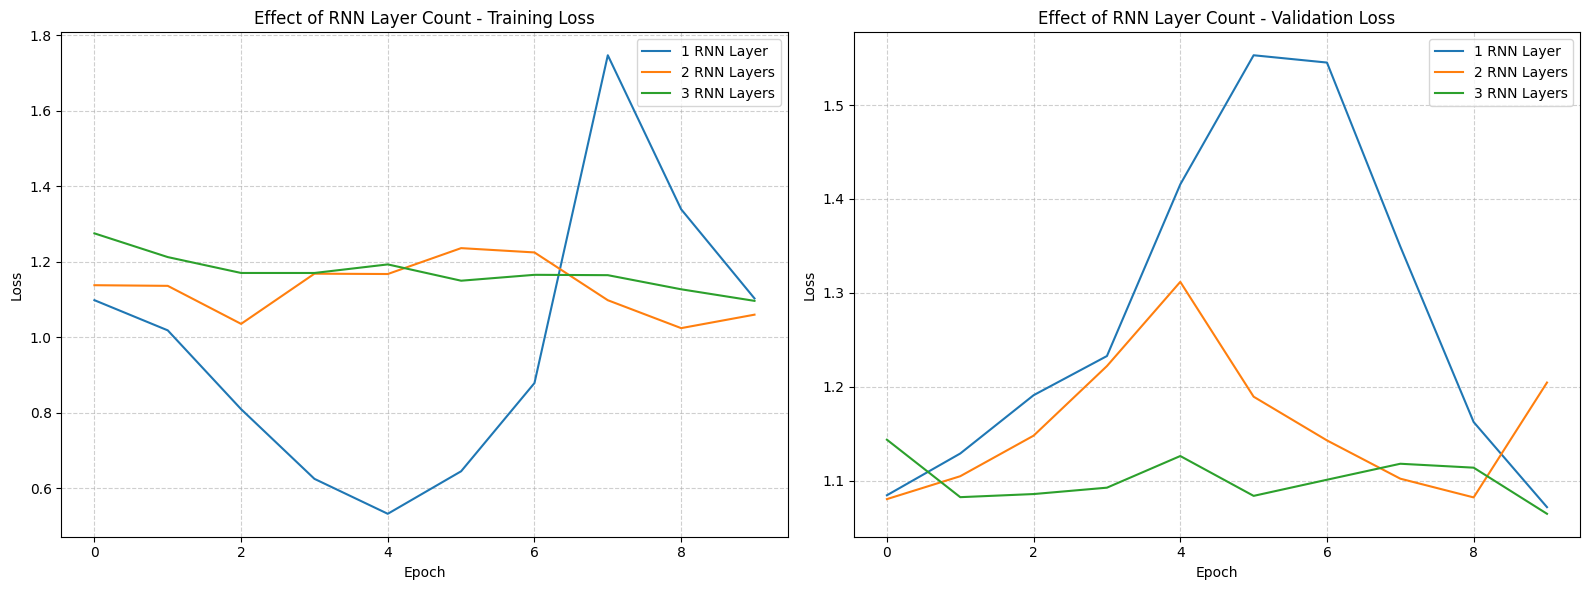

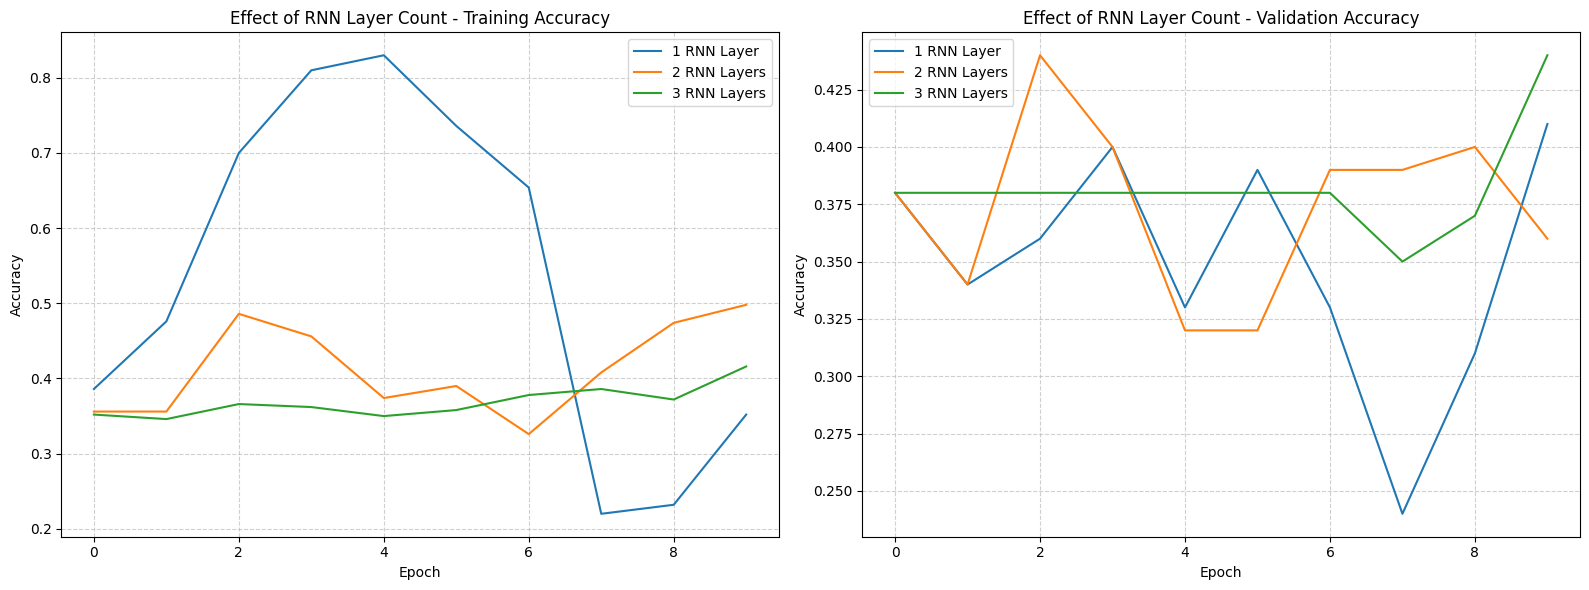

In [49]:
layer_count_variants = [
    (1, "1 RNN Layer"),
    (2, "2 RNN Layers"),
    (3, "3 RNN Layers")
]

# Run experiment
layer_count_models, layer_count_histories = experiments.run_layer_count_experiment(layer_count_variants)

### 2.2 Experiment: Number of RNN Cells per Layer


=== Training model with 32 Units ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.4370 - loss: 1.0874 - val_accuracy: 0.4500 - val_loss: 1.0735
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5272 - loss: 1.0252 - val_accuracy: 0.4200 - val_loss: 1.1859
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7297 - loss: 0.7610 - val_accuracy: 0.4300 - val_loss: 1.2437
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7954 - loss: 0.5881 - val_accuracy: 0.2700 - val_loss: 1.5783
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5609 - loss: 1.0017 - val_accuracy: 0.4300 - val_loss: 1.3279
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4373 - loss: 1.1005 - val_accuracy: 0.4200 - val_loss: 1.2858
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4595 - loss: 1.1840 - val_accuracy: 0.3800 - val_loss: 1.2386
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2609 - loss: 1.3567 - val_accuracy: 0.3800 - val_loss: 1

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_28 (SimpleRNN)       │ (None, 32)             │         4,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 863,867 (3.30 MB)

 Trainable params: 287,955 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 575,912 (2.20 MB)


=== Training model with 64 Units ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.3511 - loss: 1.0973 - val_accuracy: 0.3800 - val_loss: 1.0873
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3964 - loss: 1.0612 - val_accuracy: 0.3700 - val_loss: 1.2002
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5729 - loss: 0.9211 - val_accuracy: 0.3700 - val_loss: 1.2471
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5382 - loss: 0.9473 - val_accuracy: 0.3700 - val_loss: 1.1364
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4633 - loss: 1.1117 - val_accuracy: 0.4700 - val_loss: 1.1070
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5742 - loss: 0.9798 - val_accuracy: 0.3500 - val_loss: 1.1908
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6106 - loss: 0.8666 - val_accuracy: 0.3400 - val_loss: 1.3065
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5807 - loss: 0.8775 - val_accuracy: 0.3200 - val_loss: 1

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_29 (SimpleRNN)       │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883,067 (3.37 MB)

 Trainable params: 294,355 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 588,712 (2.25 MB)


=== Training model with 128 Units ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.4323 - loss: 1.0701 - val_accuracy: 0.3800 - val_loss: 1.0539
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4146 - loss: 1.0870 - val_accuracy: 0.2500 - val_loss: 1.1468
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3198 - loss: 1.1881 - val_accuracy: 0.3800 - val_loss: 1.1025
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3616 - loss: 1.1101 - val_accuracy: 0.3300 - val_loss: 1.0915
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3817 - loss: 1.1421 - val_accuracy: 0.4000 - val_loss: 1.0842
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3763 - loss: 1.1084 - val_accuracy: 0.3800 - val_loss: 1.1024
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3834 - loss: 1.1085 - val_accuracy: 0.4000 - val_loss: 1.0891
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4460 - loss: 1.0516 - val_accuracy: 0.4400 - val_loss: 1

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_30 (SimpleRNN)       │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,899 (3.59 MB)

 Trainable params: 313,299 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 626,600 (2.39 MB)

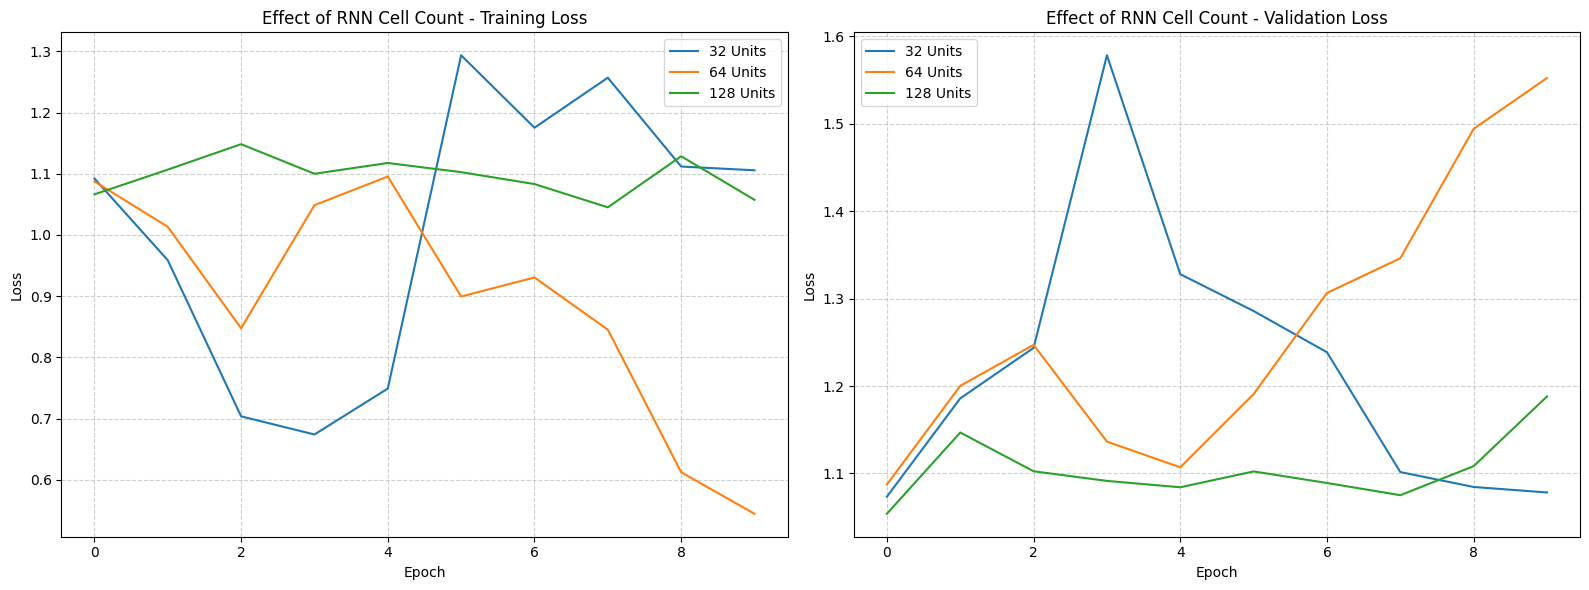

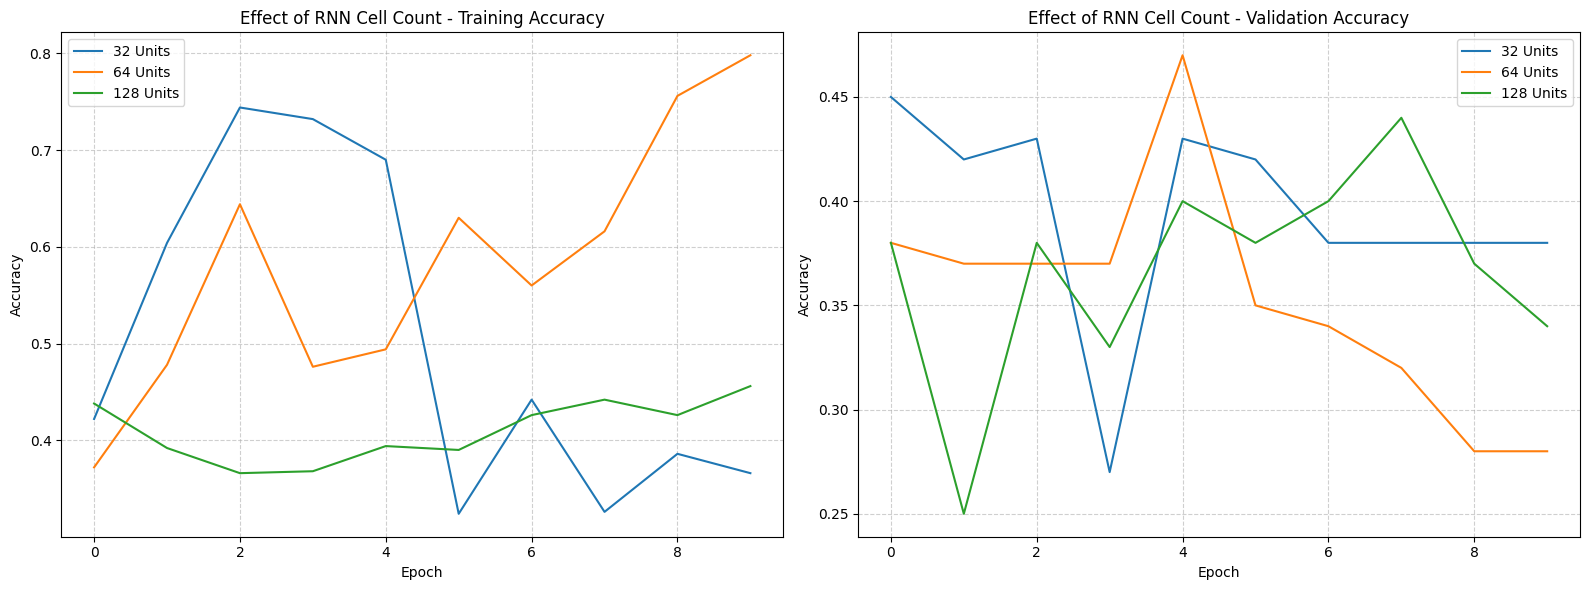

In [50]:
# Define variants for cell counts
cell_count_variants = [
    ([32], "32 Units"),
    ([64], "64 Units"),
    ([128], "128 Units")
]

# Run experiment
cell_count_models, cell_count_histories = experiments.run_cell_count_experiment(cell_count_variants)

### 2.3 Experiment: RNN Direction


=== Training model with Unidirectional RNN RNN ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.3567 - loss: 1.1107 - val_accuracy: 0.3800 - val_loss: 1.0853
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4926 - loss: 1.0353 - val_accuracy: 0.3000 - val_loss: 1.3034
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4358 - loss: 1.0651 - val_accuracy: 0.3400 - val_loss: 1.1392
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4445 - loss: 1.0729 - val_accuracy: 0.3400 - val_loss: 1.1281
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3423 - loss: 1.1800 - val_accuracy: 0.4000 - val_loss: 1.0737
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4003 - loss: 1.1027 - val_accuracy: 0.3500 - val_loss: 1.1031
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3955 - loss: 1.1247 - val_accuracy: 0.3500 - val_loss: 1.1105
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3545 - loss: 1.1545 - val_accuracy: 0.4300 - val_loss: 1

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_31 (SimpleRNN)       │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,899 (3.59 MB)

 Trainable params: 313,299 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 626,600 (2.39 MB)


=== Training model with Bidirectional RNN RNN ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.4116 - loss: 1.0628 - val_accuracy: 0.4800 - val_loss: 1.0018
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6479 - loss: 0.8403 - val_accuracy: 0.3400 - val_loss: 1.1178
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8392 - loss: 0.5516 - val_accuracy: 0.5400 - val_loss: 0.9498
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9547 - loss: 0.3059 - val_accuracy: 0.5300 - val_loss: 1.0113
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9820 - loss: 0.1550 - val_accuracy: 0.4700 - val_loss: 1.0848
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9778 - loss: 0.0969 - val_accuracy: 0.5700 - val_loss: 1.0211
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9905 - loss: 0.0524 - val_accuracy: 0.5500 - val_loss: 1.0554
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9994 - loss: 0.0336 - val_accuracy: 0.5000 - val_loss: 1

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │        58,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,028,987 (3.93 MB)

 Trainable params: 342,995 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 685,992 (2.62 MB)

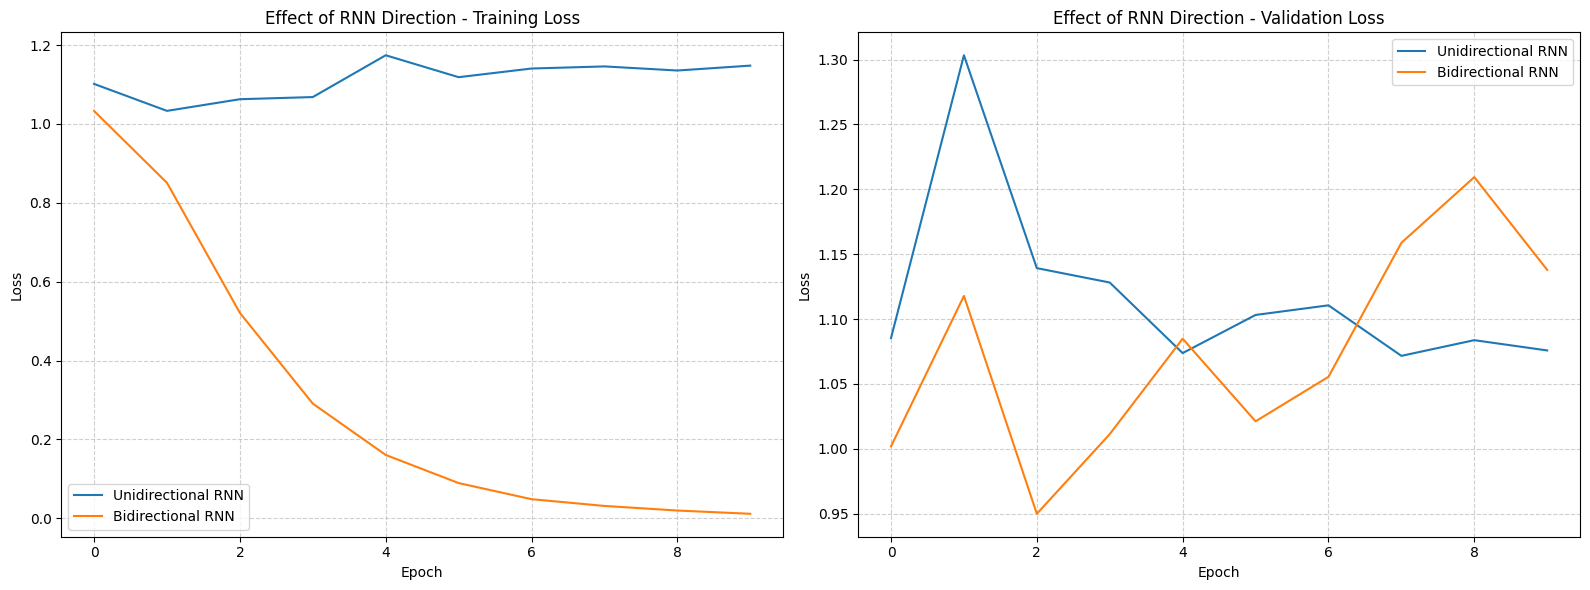

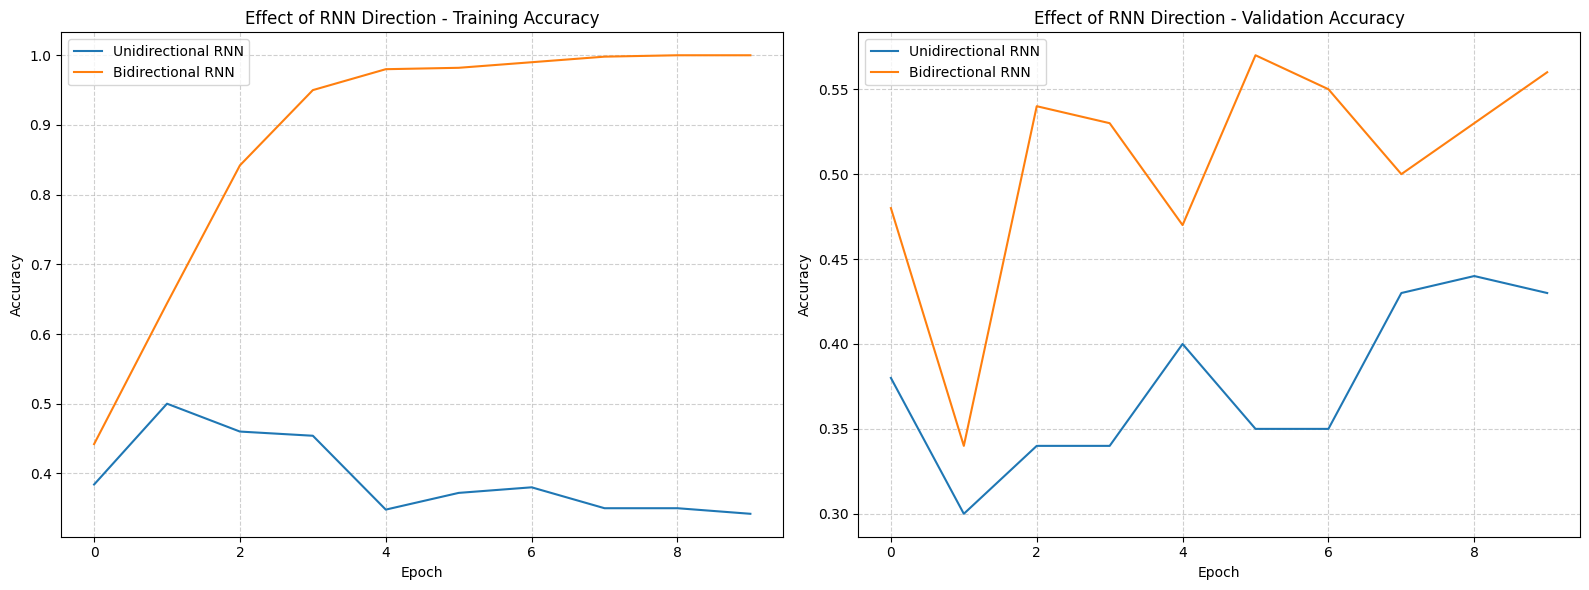

In [51]:
# Define variants for RNN direction
direction_variants = [
    (False, "Unidirectional RNN"),
    (True, "Bidirectional RNN")
]

# Run experiment
direction_models, direction_histories = experiments.run_direction_experiment(direction_variants)

## 3. From-Scratch RNN Implementation

In [62]:
keras_model_path = "../output/models/rnn/rnn_cells_32.keras"
result = experiments.compare_models_simple(keras_model_path)

Loaded Keras model from ../output/models/rnn/rnn_cells_32.keras


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_28 (SimpleRNN)       │ (None, 32)             │         4,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 863,867 (3.30 MB)

 Trainable params: 287,955 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 575,912 (2.20 MB)

Keras model has 4 layers
Processing layer 0: Embedding
Added Embedding layer: 2836 → 100
Processing layer 1: SimpleRNN
Added RNN layer: 100 → 32 (return_sequences=False)
Processing layer 2: Dropout
Added Dropout layer: rate=0.2
Processing layer 3: Dense
Added Dense layer with Softmax: 32 → 3

Scratch model structure:
Layer 0: EmbeddingLayer
Layer 1: RNNLayer
Layer 2: DropoutLayer
Layer 3: DenseLayer
Loading weights from Keras model...
Keras model has 4 layers
Scratch model has 4 layers

Keras model architecture:
  Layer 0: Embedding -> Unknown
  Layer 1: SimpleRNN -> Unknown
  Layer 2: Dropout -> Unknown
  Layer 3: Dense -> Unknown

Scratch model architecture:
  Layer 0: EmbeddingLayer
  Layer 1: RNNLayer
  Layer 2: DropoutLayer
  Layer 3: DenseLayer

Loading weights for layer 0:
Successfully loaded weights for layer 0

Loading weights for layer 1:
Loaded weights - W: (100, 32), U: (32, 32), b: (32,)
Successfully loaded weights for layer 1

Loading weights for layer 2:
Successfully loa

In [68]:
print("=== Model Comparison Result ===")
print(f"Keras Accuracy       : {result['keras_metrics']['accuracy']:.4f}")
print(f"Keras Macro F1       : {result['keras_metrics']['macro_f1']:.4f}")
print(f"Scratch Accuracy     : {result['scratch_metrics']['accuracy']:.4f}")
print(f"Scratch Macro F1     : {result['scratch_metrics']['macro_f1']:.4f}")
print(f"Model Agreement      : {result['model_agreement']:.4f}")


=== Model Comparison Result ===
Keras Accuracy       : 0.3675
Keras Macro F1       : 0.1897
Scratch Accuracy     : 0.3675
Scratch Macro F1     : 0.1897
Model Agreement      : 1.0000
